In [ ]:
#Installing required packages
!pip install -q transformers accelerate datasets bitsandbytes
!pip install bert-score nltk rouge-score evaluate

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=30da561aec52d42809afef1d3dd78d2db966b0e5b109f264f45fa9454136db26
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
#Importing libraries
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import torch
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.metrics import f1_score
import numpy as np
from bert_score import score as bertscore
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from huggingface_hub import login
login()

In [ ]:
#Loading PubMedQA (pqa_labeled) dataset
ds = load_dataset("qiaojin/PubMedQA", "pqa_labeled", split='train[:50%]')  # Reduced dataset size
data = load_dataset("qiaojin/PubMedQA", "pqa_labeled")

In [ ]:
#Loading LLaMA 2 13B model and tokenizer (chat version)

model_id = "meta-llama/Llama-2-13b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_auth_token=True)
tokenizer.pad_token = tokenizer.eos_token  # Fix padding issue

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",             # auto-distributes across available GPUs
    torch_dtype=torch.float16,     # 16-bit precision for efficiency
    load_in_4bit=True,             # Enable 4-bit quantization (saves memory)
    use_auth_token=True
)


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:898: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

# Evaluation without fine tuning

In [ ]:
# Function to compute metrics
def compute_metrics(predictions, references):
    # Initialize metric accumulators
    f1_scores = []
    bleu_scores = []
    rouge1_scores = []
    rougeL_scores = []

    rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    smooth_fn = SmoothingFunction().method1

    for pred, ref in zip(predictions, references):
        # Tokenize the predictions and references
        pred_tokens = nltk.word_tokenize(pred.lower())
        ref_tokens = nltk.word_tokenize(ref.lower())

        # F1 Score (binary approximation using common tokens)
        common = set(pred_tokens) & set(ref_tokens)
        precision = len(common) / len(set(pred_tokens)) if pred_tokens else 0
        recall = len(common) / len(set(ref_tokens)) if ref_tokens else 0
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8) if (precision + recall) else 0
        f1_scores.append(f1)

        # BLEU Score
        bleu = sentence_bleu(
            [ref_tokens],
            pred_tokens,
            smoothing_function=smooth_fn
        )
        bleu_scores.append(bleu)

        # ROUGE Scores
        rouge_scores = rouge.score(pred, ref)
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

    P, R, F1 = bertscore(predictions, references, lang="en", batch_size=64)
    # Aggregate scores
    metrics = {
        'Token-F1': np.mean(f1_scores),
        'BLEU': np.mean(bleu_scores),
        'ROUGE-1': np.mean(rouge1_scores),
        'ROUGE-L': np.mean(rougeL_scores),
        'BERTScore-P': P.mean().item(),
        'BERTScore-R': R.mean().item(),
        'BERTScore-F1': F1.mean().item()
    }

    return metrics


In [ ]:
# Evaluation BEFORE fine-tuning
print("Evaluating BEFORE fine-tuning...")

def evaluate_model(model, tokenizer, dataset, num_samples=20):
    predictions, references = [], []
    valid_count = 0

    for sample in dataset:
        if valid_count >= num_samples:
            break

        question = sample.get('question') or sample.get('QUESTION')
        context = sample.get('context') or sample.get('CONTEXTS')
        answer = sample.get('long_answer') or sample.get('LONG_ANSWER') or sample.get('final_decision')

        # Skip if any field is missing
        if not question or not answer or answer.strip() == "":
            continue

        # Flatten context
        if isinstance(context, dict):
            context = " ".join(context.get('contexts', []))
        elif isinstance(context, list):
            context = " ".join(context)
        elif context is None:
            context = ""

        # Build input prompt
        input_text = f"Question: {question}\nContext: {context}\nAnswer:"
        inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device)
        output_ids = model.generate(**inputs, max_new_tokens=64)
        generated = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        predictions.append(generated)
        references.append(answer)
        valid_count += 1

    if valid_count == 0:
        print("[ERROR] No valid samples found for evaluation. Please check your dataset.")
    return predictions, references


pred_before, ref_before = evaluate_model(model, tokenizer, ds, num_samples=20)

if not pred_before or not ref_before:
    raise ValueError("No valid prediction-reference pairs found for evaluation.")

metrics_before = compute_metrics(pred_before, ref_before)

print("\n--- Metrics BEFORE Fine-Tuning ---")
for k, v in metrics_before.items():
    print(f"{k}: {v:.4f}")


Evaluating BEFORE fine-tuning...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Metrics BEFORE Fine-Tuning ---
Token-F1: 0.2292
BLEU: 0.0197
ROUGE-1: 0.1785
ROUGE-L: 0.1090
BERTScore-P: 0.7990
BERTScore-R: 0.8706
BERTScore-F1: 0.8330


# FINE TUNING

In [ ]:
# Format for prompt
def format_example(example):
    context = " ".join(example['context']['contexts']) if example['context']['contexts'] else ""
    text = f"Question: {example['question']} Context: {context} Long Answer: {example['long_answer']}"
    return {'text': text}

# Tokenize and set up labels
def tokenize_and_prepare_labels(examples):
    inputs = tokenizer(examples['text'], max_length=512, truncation=True, padding="max_length")
    inputs['labels'] = inputs['input_ids'].copy()
    return inputs

# Apply formatting and tokenization
ds_train = ds.map(format_example)
ds_train = ds_train.map(tokenize_and_prepare_labels, batched=True)
ds_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

LORA CONFIGURATION

In [ ]:
from peft import LoraConfig, get_peft_model
# Configure LoRA for minimal updates
lora_config = LoraConfig(
    r=4,  # Reduced rank
    lora_alpha=32,
    target_modules=["q_proj"],  # Limiting the layers
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [ ]:
torch.cuda.empty_cache()


In [ ]:
# Training setup
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    logging_dir='./logs',
    logging_steps=10,
    remove_unused_columns=False,
    report_to="none",
    label_names=["labels"]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train
)

# Start training
trainer.train()

Step,Training Loss
10,3.065400
20,2.973800


Step,Training Loss
10,3.065400
20,2.973800
30,2.302600
40,2.373500
50,2.060900
60,2.200500
70,2.115100
80,2.034400
90,1.822800
100,1.639300


TrainOutput(global_step=125, training_loss=2.12499800491333, metrics={'train_runtime': 3835.7331, 'train_samples_per_second': 0.13, 'train_steps_per_second': 0.033, 'total_flos': 1.974322593792e+16, 'train_loss': 2.12499800491333, 'epoch': 1.0})

In [ ]:
# Evaluation AFTER fine-tuning
print("\nEvaluating AFTER fine-tuning...")
pred_after, ref_after = evaluate_model(model, tokenizer, ds, num_samples=20)
metrics_after = compute_metrics(pred_after, ref_after)

print("\n--- Comparative Evaluation ---")
print("{:<20} {:<15} {:<15}".format("Metric", "Before", "After"))
print("-" * 50)
for k in metrics_before.keys():
    before = metrics_before[k]
    after = metrics_after[k]
    print("{:<20} {:<15.4f} {:<15.4f}".format(k, before, after))



Evaluating AFTER fine-tuning...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Comparative Evaluation ---
Metric               Before          After          
--------------------------------------------------
Token-F1             0.2292          0.2320         
BLEU                 0.0197          0.0198         
ROUGE-1              0.1785          0.1832         
ROUGE-L              0.1090          0.1129         
BERTScore-P          0.7990          0.8003         
BERTScore-R          0.8706          0.8714         
BERTScore-F1         0.8330          0.8342         


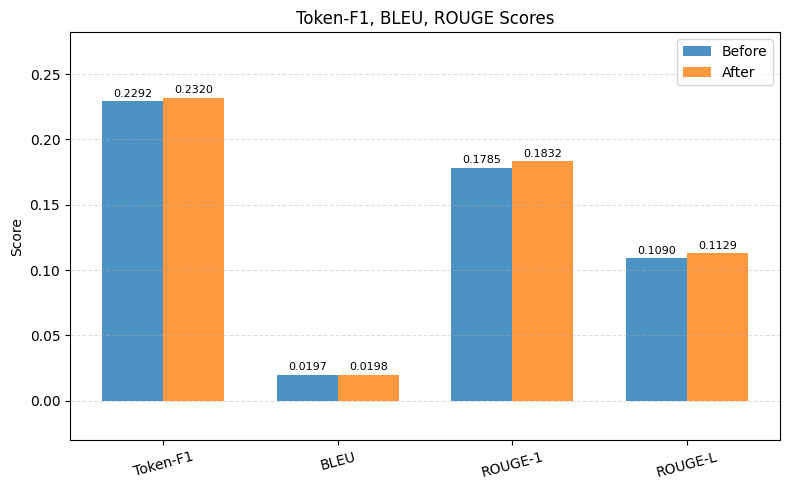

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#metrics to plot
plot1_keys = ['Token-F1', 'BLEU', 'ROUGE-1', 'ROUGE-L']
before_vals_1 = [metrics_before[k] for k in plot1_keys]
after_vals_1 = [metrics_after[k] for k in plot1_keys]

x1 = np.arange(len(plot1_keys))
width = 0.35

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x1 - width/2, before_vals_1, width, label='Before', alpha=0.8)
bars2 = plt.bar(x1 + width/2, after_vals_1, width, label='After', alpha=0.8)

plt.ylabel('Score')
plt.title('Token-F1, BLEU, ROUGE Scores')
plt.xticks(x1, plot1_keys, rotation=15)
plt.ylim(min(min(before_vals_1), min(after_vals_1)) - 0.05, max(max(before_vals_1), max(after_vals_1)) + 0.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

for bar in bars1 + bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f'{yval:.4f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


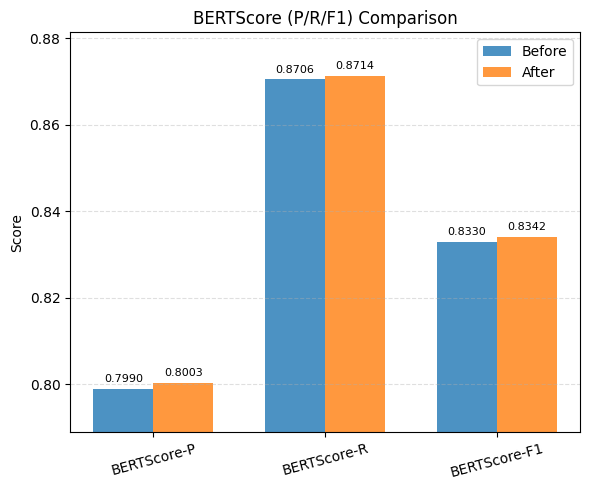

In [ ]:
# Selecting BERTScore keys
plot2_keys = ['BERTScore-P', 'BERTScore-R', 'BERTScore-F1']
before_vals_2 = [metrics_before[k] for k in plot2_keys]
after_vals_2 = [metrics_after[k] for k in plot2_keys]

x2 = np.arange(len(plot2_keys))

plt.figure(figsize=(6, 5))
bars3 = plt.bar(x2 - width/2, before_vals_2, width, label='Before', alpha=0.8)
bars4 = plt.bar(x2 + width/2, after_vals_2, width, label='After', alpha=0.8)

plt.ylabel('Score')
plt.title('BERTScore (P/R/F1) Comparison')
plt.xticks(x2, plot2_keys, rotation=15)
plt.ylim(min(min(before_vals_2), min(after_vals_2)) - 0.01, max(max(before_vals_2), max(after_vals_2)) + 0.01)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

for bar in bars3 + bars4:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.4f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
def chat_pubmedqa(question, context=""):
    system_prompt = "You are a helpful biomedical assistant who provides clear, accurate, and detailed answers to biomedical questions."

    # Construct the prompt explicitly as per official guidelines
    if context:
        user_message = f"Context:\n{context}\n\nQuestion:\n{question}"
    else:
        user_message = f"Question:\n{question}"

    prompt = f"<s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\n{user_message} [/INST]"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        temperature=0.7,
        top_p=0.95,
        repetition_penalty=1.2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response.split("[/INST]")[-1].strip()

    return response


In [ ]:
# Testing using Interactive chatbot loop

print("\n🧠 PubMedQA Chatbot Ready. Type 'exit' to quit.\n")
while True:
    user_q = input("🧑 You: ")
    if user_q.lower() in ["exit", "quit"]:
        print("👋 Goodbye!")
        break

    #
    response = chat_pubmedqa(user_q)
    print("🤖 Assistant:", response)




🧠 PubMedQA Chatbot Ready. Type 'exit' to quit.

🧑 You: exit
👋 Goodbye!


# LLM as a Judge

In [ ]:
import random
#loading judge model
judge_model_id = "NousResearch/Llama-2-13b-chat-hf"
tokenizer_judge = AutoTokenizer.from_pretrained(judge_model_id, trust_remote_code=True)
model_judge = AutoModelForCausalLM.from_pretrained(
    judge_model_id,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)
model_judge.eval()

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/196 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((5120,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((5120,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((5120,), eps=1e-05

In [ ]:
import random

#  Function to evaluate using a judge model
def judge_with_llama(reference, prediction):
    prompt = f"""
You are an expert evaluator in healthcare QA systems.

Reference Answer:
{reference}

Model's Predicted Answer:
{prediction}

Please rate the predicted answer based on relevance, accuracy, and completeness.
Return only a number from 1 (very poor) to 5 (excellent).
"""
    inputs = tokenizer_judge(prompt, return_tensors="pt").to(model_judge.device)
    outputs = model_judge.generate(**inputs, max_new_tokens=50)
    rating_text = tokenizer_judge.decode(outputs[0], skip_special_tokens=True)

    # Trying to extract the first valid number
    for token in rating_text:
        if token in ['1', '2', '3', '4', '5']:
            return int(token)
    return None  # fallback if no valid score is detected

# Defining which predictions to score (e.g., after fine-tuning)
source_predictions = pred_after
source_references = ref_after

# Running LLM-as-a-Judge evaluation
sampled_indexes = random.sample(range(len(source_predictions)), min(20, len(source_predictions)))
ratings = []

for idx in sampled_indexes:
    ref = source_references[idx]
    pred = source_predictions[idx]
    score = judge_with_llama(ref, pred)
    print(f"Example {idx}: Rating = {score}")
    if score is not None:
        ratings.append(score)

# Output average score
if ratings:
    avg_rating = sum(ratings) / len(ratings)
    print(f"\nAverage LLM-as-a-Judge Score (over {len(ratings)} samples): {avg_rating:.2f} / 5")
else:
    print("No valid ratings collected.")


Example 3: Rating = 2
Example 0: Rating = 1
Example 8: Rating = 1
Example 7: Rating = 1
Example 16: Rating = 4
Example 2: Rating = 2
Example 11: Rating = 1
Example 1: Rating = 1
Example 10: Rating = 2
Example 17: Rating = 5
Example 12: Rating = 1
Example 6: Rating = 3
Example 18: Rating = 1
Example 15: Rating = 1
Example 13: Rating = 2
Example 9: Rating = 2
Example 4: Rating = 5
Example 14: Rating = 2
Example 5: Rating = 2
Example 19: Rating = 5

Average LLM-as-a-Judge Score (over 20 samples): 2.20 / 5


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 132.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.5 MB/s eta 0:00:00


User Interface using gradio:

In [ ]:
import gradio as gr

# Definining the chatbot function
def medical_chatbot(user_question):

    system_prompt = "You are a helpful biomedical assistant who provides clear, accurate, and detailed answers to biomedical questions."

    prompt = f"<s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\nQuestion:\n{user_question} [/INST]"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        temperature=0.7,
        top_p=0.95,
        repetition_penalty=1.2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response.split("[/INST]")[-1].strip()

    return response

# Creating Gradio Interface
iface = gr.Interface(
    fn=medical_chatbot,
    inputs=gr.Textbox(lines=3, placeholder="Enter your medical question here..."),
    outputs="text",
    title="🩺 Medical QA Chatbot",
    description="Ask biomedical questions and get detailed answers based on fine-tuned LLaMA-2 model!",
    theme="default"
)

# Launching the app
iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://63aafa6c20ec3afc5a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
